## Machine Learning for Bitcoin Price Prediction and Sentiment Analysis

In this project I have two problems I want to solve, they are

 1. I want to recognize patterns in BTC/USDT to forecast what will happen to the price in the next 12 hours with some technical indicators (Engineering features)
 2. I want to get sentiment analysis from any source like CoinDesk or CryptoPanic

Let's focus on number one first, right now, we need bitcoin price data, it's more important than anything else, but wait... how can we get up-to-date data from the market? Ohh I know, previously I had a similar project like this and I used ccxt to get bitget data. Oke, lets get bitcoin data from bitget...

***DISCLAIMER***

***Everything I do here is just for brain training and personal experimentation. Not everything should be trusted or used as a benchmark for investment or trading. The goal is just to learn and apply the Data Science knowledge that I have learned so far.***



In [1]:
# pip install pycoingecko ccxt ta snscrape

In [2]:
import pandas as pd
import ccxt

### Get Data from API

In [3]:
bitget = ccxt.bitget()
ohlcv = bitget.fetch_ohlcv('BTC/USDT', timeframe='1h', limit=1000)

### EDA (Exploratory Data Analysis)

In [4]:
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

df

,open,high,low,close,volume
timestamp,,,,,
2025-03-04 15:00:00,83216.68,83387.09,81520.90,82999.99,1002.587290
2025-03-04 16:00:00,82999.99,83790.00,82022.41,83552.68,1179.901143
2025-03-04 17:00:00,83552.68,85530.27,83429.00,85450.72,884.769535
2025-03-04 18:00:00,85450.72,86900.00,85173.18,86765.01,812.538519
2025-03-04 19:00:00,86765.01,88467.73,86535.02,88200.01,1195.767062
...,...,...,...,...,...
2025-04-15 02:00:00,84966.20,85284.50,84697.47,85220.32,296.418309
2025-04-15 03:00:00,85220.32,85403.63,85068.00,85365.43,345.552030
2025-04-15 04:00:00,85365.43,85511.68,85155.07,85485.87,314.500596


Right now we have the data, but we don't know if the data is good or there are actually zero values or missing values? But I'm pretty sure if the data is up-to-date from the market, we won't have zero/missing values, but let's check first

In [5]:
#Check Missing Values
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2025-03-04 15:00:00 to 2025-04-15 06:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1000 non-null   float64
 1   high    1000 non-null   float64
 2   low     1000 non-null   float64
 3   close   1000 non-null   float64
 4   volume  1000 non-null   float64
dtypes: float64(5)
memory usage: 46.9 KB


,open,high,low,close,volume
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,83897.264280,84246.455350,83561.982620,83899.447820,375.060114
std,2808.649191,2784.765309,2849.135769,2808.968313,432.975775
min,74828.000000,75486.720000,74522.270000,74828.000000,24.073424
25%,82567.252500,82881.307500,82249.995000,82567.252500,149.520707
50%,83883.450000,84126.735000,83617.345000,83889.445000,244.524613
75%,85345.312500,85716.702500,85093.030000,85356.940000,433.774531
max,92728.210000,92794.110000,92135.000000,92728.210000,5328.027275


okay, thats good, we dont have missing values, lets see the price of bitcoin in the last 1000 candles

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

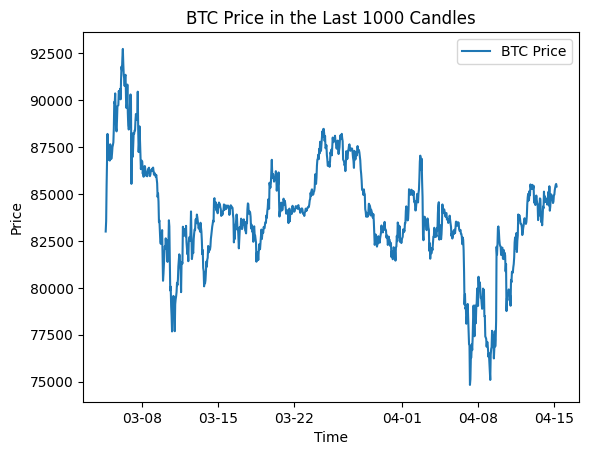

In [7]:
#Check Linechar, i want to see the price of BTC in the last 1000 candles

plt.plot(df.index, df['close'], label='BTC Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('BTC Price in the Last 1000 Candles')
plt.legend()
plt.show()


### Analyze Data
Previously we see the data and i think the data is healthy, we can up the stairs. In this part we will analyze the data, and we have to recognize what features make a good prediction. Actually, I don't have the experience to know what features make a good prediction. I am a trader and I know that the market is actually unpredictable and actually traders only use historical data to predict the future... and that's hard.

But, lets get the technical indicator first, i will use RSI, ATR, Bollinger Bands, Volatility, etc. (We will use ta library)

In [8]:
import numpy as np
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange

atr = AverageTrueRange(df['high'], df['low'], df['close'], window=14)
bb = BollingerBands(close=df['close'], window=20, window_dev=2)

In [9]:
df_analyze = df.copy() # Copy data

df_analyze['close_future_6'] = df_analyze['close'].shift(6)
df_analyze['price_movement'] = (df_analyze['close_future_6'] > df_analyze['close']).astype(int)
df_analyze['close_future_1'] = df_analyze['close'].shift(3)
df_analyze['candle_body_pct'] = (df_analyze['close'] - df_analyze['open']) / (df_analyze['high'] - df_analyze['low'] + 1e-6)
df_analyze['volume_change'] = df_analyze['volume'].diff()
df_analyze['bb_width'] = bb.bollinger_hband() - bb.bollinger_lband()
df_analyze['close_pct_1'] = df_analyze['close'].pct_change(1)
df_analyze['return_lag_1'] = df_analyze['close_pct_1'].shift(1)
df_analyze['volatility_5'] = df_analyze['close_pct_1'].rolling(5).std()
df_analyze['ema_10'] = df_analyze['close'].ewm(span=10).mean()
df_analyze['ema_20'] = df_analyze['close'].ewm(span=20).mean()
df_analyze['ema_10_rel'] = df_analyze['close'] / df_analyze['close'].ewm(span=10).mean() - 1
df_analyze['ema_20_rel'] = df_analyze['close'] / df_analyze['close'].ewm(span=20).mean() - 1
df_analyze['ema_cross'] = ((df_analyze['ema_10'] > df_analyze['ema_20']) &
                          (df_analyze['ema_10'].shift(1) <= df_analyze['ema_20'].shift(1))).astype(int)
df_analyze['rsi'] = RSIIndicator(df_analyze['close'], window=14).rsi()
df_analyze['rsi_change'] = df_analyze['rsi'] - df_analyze['rsi'].shift(6)
df_analyze['bb_width_change'] = df_analyze['bb_width'].pct_change(3)
df_analyze['vol_accel'] = df_analyze['volume'].pct_change().pct_change()
df_analyze['returns'] = df_analyze['close'].pct_change() * 100
df_analyze['atr'] = atr.average_true_range()
df_analyze['wick_upper'] = df['high'] - df[['open', 'close']].max(axis=1)
df_analyze['wick_lower'] = df[['open', 'close']].min(axis=1) - df['low']
df_analyze['price_activity_ratio'] = (df_analyze['high'] - df_analyze['low']) / (df_analyze['high'].rolling(12).mean() - df_analyze['low'].rolling(12).mean())
df_analyze['volume_ratio_4h'] = df_analyze['volume'] / df_analyze['volume'].rolling(4).mean()
df_analyze['rsi_slope'] = df_analyze['rsi'] - df_analyze['rsi'].shift(3)
df_analyze['atr_change'] = df_analyze['atr'].pct_change(4)
df_analyze['close_momentum_6h'] = df_analyze['close'] / df_analyze['close'].shift(6) - 1
df_analyze['close_momentum_12h'] = df_analyze['close'] / df_analyze['close'].shift(12) - 1
df_analyze['close_momentum_24h'] = df_analyze['close'] / df_analyze['close'].shift(24) - 1
df_analyze['price_zscore'] = (df_analyze['close'] - df_analyze['close'].rolling(50).mean()) / df_analyze['close'].rolling(50).std()
df_analyze['hour'] = df_analyze.index.hour
df_analyze['hour_sin'] = np.sin(2 * np.pi * df_analyze.index.hour / 24)
df_analyze['hour_cos'] = np.cos(2 * np.pi * df_analyze.index.hour / 24)
df_analyze['day_of_week'] = df_analyze.index.dayofweek
df_analyze['close_pct_3'] = df_analyze['close'].pct_change(3)
df_analyze['log_return'] = np.log(df_analyze['close'] / df_analyze['close'].shift(1))
df_analyze['close_lag_1'] = df_analyze['close'].shift(1)
df_analyze['hl_range'] = df_analyze['high'] - df_analyze['low']

df_analyze.tail()

,open,high,low,close,volume,close_future_6,price_movement,close_future_1,candle_body_pct,volume_change,...,close_momentum_24h,price_zscore,hour,hour_sin,hour_cos,day_of_week,close_pct_3,log_return,close_lag_1,hl_range
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-04-15 02:00:00,84966.20,85284.50,84697.47,85220.32,296.418309,84860.07,0,84599.99,0.432891,-55.073433,...,0.001118,1.334477,2,0.500000,8.660254e-01,1,0.007333,0.002986,84966.20,587.03
2025-04-15 03:00:00,85220.32,85403.63,85068.00,85365.43,345.552030,84700.03,0,84934.24,0.432351,49.133721,...,0.009492,1.616670,3,0.707107,7.071068e-01,1,0.005077,0.001701,85220.32,335.63
2025-04-15 04:00:00,85365.43,85511.68,85155.07,85485.87,314.500596,84517.01,0,84966.20,0.337736,-31.051434,...,0.007202,1.830765,4,0.866025,5.000000e-01,1,0.006116,0.001410,85365.43,356.61
2025-04-15 05:00:00,85485.87,85855.86,85473.01,85535.48,373.851146,84599.99,0,85220.32,0.129581,59.350550,...,0.011416,1.912758,5,0.965926,2.588190e-01,1,0.003698,0.000580,85485.87,382.85
2025-04-15 06:00:00,85535.48,85678.00,85362.00,85400.22,217.607356,84934.24,0,85365.43,-0.428038,-156.243790,...,0.009101,1.570206,6,1.000000,6.123234e-17,1,0.000408,-0.001583,85535.48,316.00


In [10]:
print("Sebelum dilakukan handling")
print(df_analyze.info())

df_analyze.dropna(inplace=True)
print("\n----------------------------\n")

print("Setelah dilakukan handling")
print(df_analyze.info())

Sebelum dilakukan handling
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2025-03-04 15:00:00 to 2025-04-15 06:00:00
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  1000 non-null   float64
 1   high                  1000 non-null   float64
 2   low                   1000 non-null   float64
 3   close                 1000 non-null   float64
 4   volume                1000 non-null   float64
 5   close_future_6        994 non-null    float64
 6   price_movement        1000 non-null   int64  
 7   close_future_1        997 non-null    float64
 8   candle_body_pct       1000 non-null   float64
 9   volume_change         999 non-null    float64
 10  bb_width              981 non-null    float64
 11  close_pct_1           999 non-null    float64
 12  return_lag_1          998 non-null    float64
 13  volatility_5          995 non-null    float64
 14  ema_10   

That's... quite a lot isn't it hehehe? honestly, I'm still learning and I wasn't sure which features would give the best prediction results. So I decided to try as many reasonable features as I could think of (mostly from technical indicators and price-related patterns). Later on, I can use feature selection or model evaluation to figure out which ones actually help. For now, it's more like learning by doing and seeing what works.


### Model Machine Learning
You all know about LSTM or Long Short Term Memory? i will use that in this prediction, reason? i dont know, ups sorry, i know the reason hehehe. Because I think instead of using linear regression because the current condition of bitcoin is very volatile and linear regression will be overwhelmed in predicting it, therefore I choose LSTM because it can handle volatility (but I also know that LSTM has the potential for overfitting especially the features I use a lot lol).

**For this project, I’m predicting two targets: the current price, and the price from six hours ago (by shifting the price column upward). My idea is to give the model a short-term and slightly mid-term perspective, so it can learn both recent patterns and a bit of context from the past.**




In [11]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression

In [12]:
selected_features = [
    'open', 'high', 'low', 'volume',
    'candle_body_pct', 'volume_change', 'bb_width', 'close_pct_1', 'return_lag_1',
    'volatility_5', 'ema_10_rel', 'ema_20_rel',
    'rsi', 'rsi_change', 'rsi_slope',
    'bb_width_change', 'vol_accel', 'returns', 'atr', 'atr_change',
    'wick_upper', 'wick_lower', 'price_activity_ratio', 'volume_ratio_4h',
    'close_momentum_6h', 'close_momentum_12h', 'close_momentum_24h',
    'price_zscore', 'log_return', 'hl_range'
]

selector = SelectKBest(f_regression, k=20)
X_selected = selector.fit_transform(df_analyze[selected_features], df_analyze['close'])

selected_features = [selected_features[i] for i in selector.get_support(indices=True)]
print("Selected features:", selected_features)

y_multi = df_analyze[['close', 'close_future_6']].dropna()

y_data_reg = df_analyze['close'].values.reshape(-1, 1)
y_data_clf = df_analyze['price_movement'].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_aligned = df_analyze.loc[y_multi.index, selected_features].values

X_scaled = scaler_X.fit_transform(X_aligned)
y_scaled_reg = scaler_y.fit_transform(y_data_reg)
y_scaled_multi = scaler_y.fit_transform(y_multi.values)

df_scaled = np.hstack([y_scaled_multi, X_scaled])

df_scaled

Selected features: ['open', 'high', 'low', 'volume', 'bb_width', 'close_pct_1', 'volatility_5', 'ema_10_rel', 'ema_20_rel', 'rsi', 'atr', 'atr_change', 'wick_upper', 'wick_lower', 'close_momentum_6h', 'close_momentum_12h', 'close_momentum_24h', 'price_zscore', 'log_return', 'hl_range']


array([[0.92862374, 0.99635296, 1.        , ..., 0.58766014, 0.33924641,
        0.27392325],
       [0.88456255, 1.        , 0.90668462, ..., 0.53909206, 0.42829386,
        0.20237884],
       [0.87106632, 0.92463536, 0.8636644 , ..., 0.51458006, 0.48222187,
        0.11466484],
       ...,
       [0.68222856, 0.58639533, 0.6585832 , ..., 0.79334915, 0.52041083,
        0.04984241],
       [0.68540418, 0.59141742, 0.66611063, ..., 0.80324004, 0.5120529 ,
        0.05386488],
       [0.67674595, 0.6116468 , 0.66921123, ..., 0.76191743, 0.49026712,
        0.04361709]])

I split the data manually, I don't use train-test-split because it will make the prediction overfitting (because the past will learn the future, it's crazy, it doesn't make sense). By the way, I split the data into two parts, first regression and classification, I just want the model to have more information about the price (and to understand about volatility).

In [13]:
window_size = 60

def create_sequences(X, y, window=60):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq_reg = create_sequences(X_scaled, y_scaled_reg, window=window_size)
_, y_seq_clf = create_sequences(X_scaled, y_data_clf, window=window_size)

X_seq, y_seq = create_sequences(X_scaled, y_scaled_multi, window_size)

split_index = int(len(X_seq) * 0.7)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train_reg, y_test_reg = y_seq_reg[:split_index], y_seq_reg[split_index:]
y_train_clf, y_test_clf = y_seq_clf[:split_index], y_seq_clf[split_index:]

In [14]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(128, return_sequences=True)(input_layer)
x = LSTM(64)(x)
output_reg = Dense(1, name='regression')(x)
output_clf = Dense(1, activation='sigmoid', name='classification')(x)

model = Model(inputs=input_layer, outputs=[output_reg, output_clf])
model.compile(
    optimizer='adam',
    loss={'regression': 'mse', 'classification': 'binary_crossentropy'},
    metrics={'regression': 'mae', 'classification': 'accuracy'}
)

model.summary()

es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(
    X_train, {'regression': y_train_reg, 'classification': y_train_clf},
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 60, 128)   │     76,288 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │         65 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         65 │ lstm_1[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,826 (491.51 KB)

 Trainable params: 125,826 (491.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - classification_accuracy: 0.5096 - classification_loss: 0.7013 - loss: 0.8008 - regression_loss: 0.0995 - regression_mae: 0.2399 - val_classification_accuracy: 0.5520 - val_classification_loss: 0.6900 - val_loss: 0.7071 - val_regression_loss: 0.0173 - val_regression_mae: 0.1217
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - classification_accuracy: 0.5472 - classification_loss: 0.6882 - loss: 0.6958 - regression_loss: 0.0075 - regression_mae: 0.0706 - val_classification_accuracy: 0.4480 - val_classification_loss: 0.6951 - val_loss: 0.7026 - val_regression_loss: 0.0070 - val_regression_mae: 0.0707
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - classification_accuracy: 0.5605 - classification_loss: 0.6817 - loss: 0.6866 - regression_loss: 0.0051 - regression_mae: 0.0567 - val_classification_accuracy: 0.5520 - val_classification_loss: 0.6870 - val_loss: 0.6908 - val_regression_loss: 0.0050 - val_regression_mae: 0.0575
Epo

In [15]:
y_pred_reg, y_pred_clf = model.predict(X_test)
y_pred_reg_2d = np.concatenate([y_pred_reg, np.zeros_like(y_pred_reg)], axis=1)
y_pred_reg_inv = scaler_y.inverse_transform(y_pred_reg_2d)[:, 0]

y_test_reg_2d = np.concatenate([y_test_reg, np.zeros_like(y_test_reg)], axis=1)
y_test_reg_inv = scaler_y.inverse_transform(y_test_reg_2d)[:, 0]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


Regression Evaluation
MAE   : 814.0456
MedAE : 652.1306
MAPE: 1.00%
R^2   : 0.8538
------------------


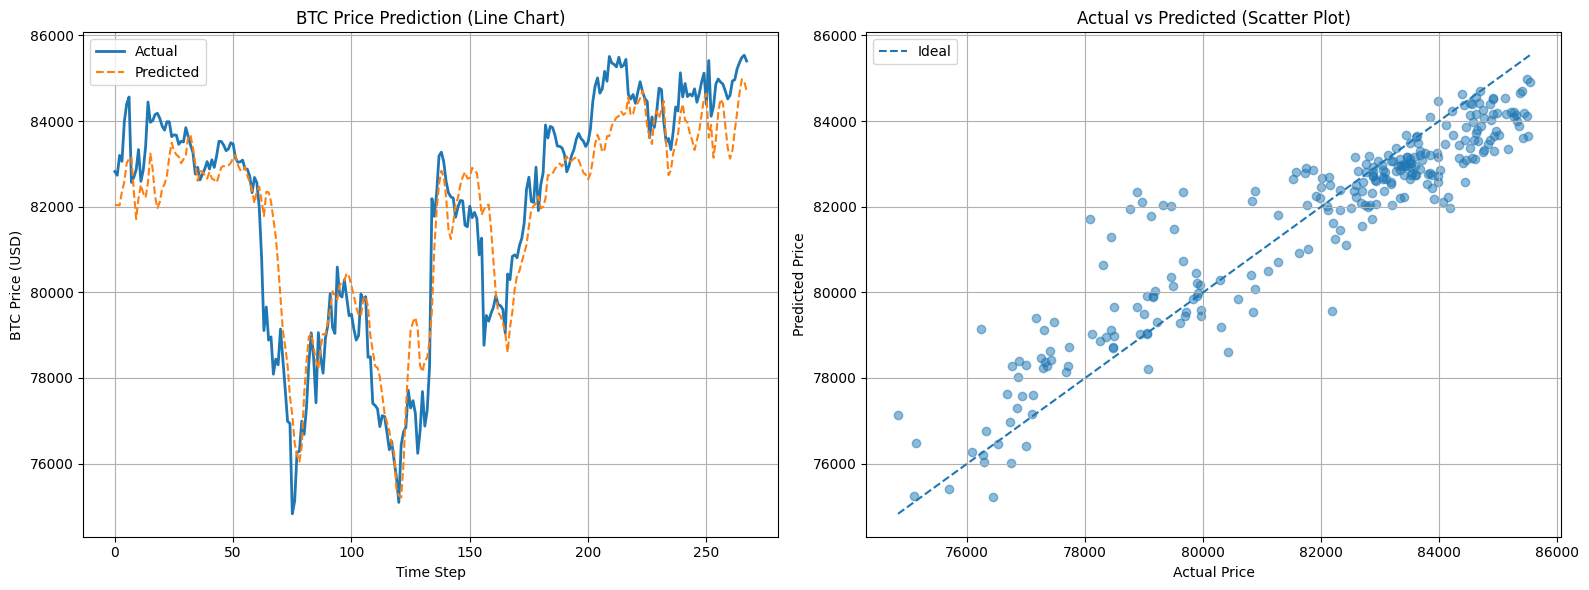

In [16]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score

mae = mean_absolute_error(y_test_reg_inv, y_pred_reg_inv)
medae = median_absolute_error(y_test_reg_inv, y_pred_reg_inv)
mape = np.mean(np.abs((y_test_reg_inv - y_pred_reg_inv) / y_test_reg_inv)) * 100
r2 = r2_score(y_test_reg_inv, y_pred_reg_inv)

print('Regression Evaluation')
print(f"MAE   : {mae:.4f}")
print(f"MedAE : {medae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2   : {r2:.4f}")
print('------------------')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(y_test_reg_inv[:360], label='Actual', linewidth=2)
axs[0].plot(y_pred_reg_inv[:360], label='Predicted', linestyle='--')
axs[0].set_title('BTC Price Prediction (Line Chart)')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('BTC Price (USD)')
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(y_test_reg_inv, y_pred_reg_inv, alpha=0.5)
axs[1].plot([min(y_test_reg_inv), max(y_test_reg_inv)],
            [min(y_test_reg_inv), max(y_test_reg_inv)], '--', label='Ideal')
axs[1].set_title('Actual vs Predicted (Scatter Plot)')
axs[1].set_xlabel('Actual Price')
axs[1].set_ylabel('Predicted Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Wait...
Is the model actually good or is there a problem? I'm always skeptical of the models I build, let's do a walk forward test.

In [17]:
walk_preds = []
walk_truth = []

input_seq = X_test[0].copy()

for i in range(len(X_test)):
    pred_reg, pred_clf = model.predict(input_seq[np.newaxis, :, :], verbose=0)
    pred = pred_reg[0][0]
    walk_preds.append(pred)
    walk_truth.append(y_test_reg[i][0])

    if i + 1 < len(X_test):
        next_row = X_test[i + 1, -1, :]
        next_row_with_pred = next_row.copy()
        next_row_with_pred[0] = pred
        input_seq = np.vstack([input_seq[1:], [next_row_with_pred]])

In [18]:
walk_preds_2d = np.concatenate([np.array(walk_preds).reshape(-1, 1), np.zeros_like(np.array(walk_preds).reshape(-1, 1))], axis=1)
walk_preds_inv = scaler_y.inverse_transform(walk_preds_2d)[:, 0]
walk_truth_2d = np.concatenate([np.array(walk_truth).reshape(-1, 1), np.zeros_like(np.array(walk_truth).reshape(-1, 1))], axis=1)
walk_truth_inv = scaler_y.inverse_transform(walk_truth_2d)[:, 0]

mae_walk = mean_absolute_error(walk_truth_inv, walk_preds_inv)
mape_walk = np.mean(np.abs((walk_truth_inv - walk_preds_inv) / walk_truth_inv)) * 100
r2_walk = r2_score(walk_truth_inv, walk_preds_inv)

print(f"[Walk-Forward] MAE  : {mae_walk:.2f}")
print(f"[Walk-Forward] MAPE : {mape_walk:.2f}%")
print(f"[Walk-Forward] R²   : {r2_walk:.4f}")

[Walk-Forward] MAE  : 926.88
[Walk-Forward] MAPE : 1.14%
[Walk-Forward] R²   : 0.8172


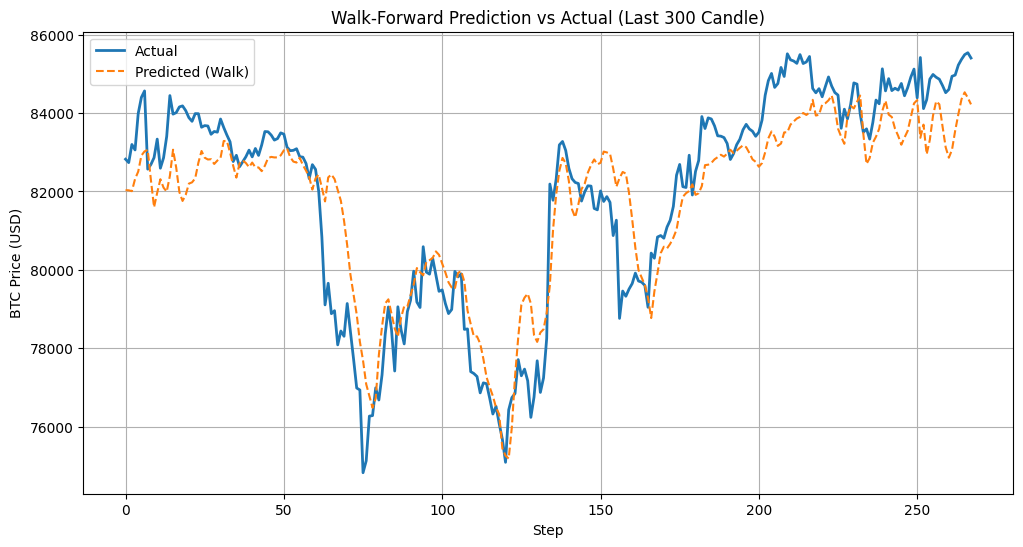

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(walk_truth_inv[:300], label='Actual', linewidth=2)
plt.plot(walk_preds_inv[:300], label='Predicted (Walk)', linestyle='--')
plt.title('Walk-Forward Prediction vs Actual (Last 300 Candle)')
plt.xlabel('Step')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

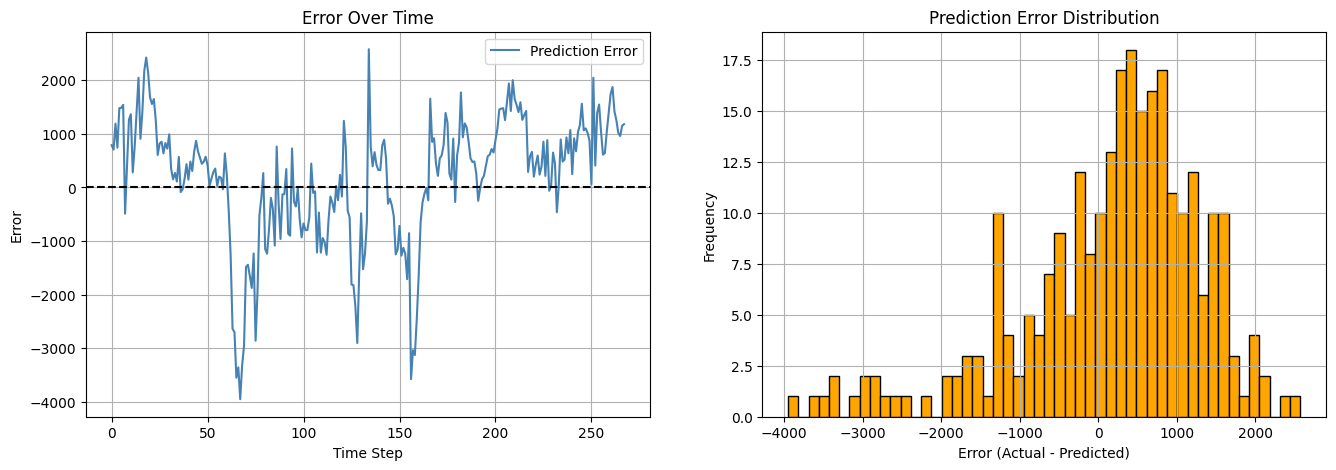

In [20]:
error = walk_truth_inv.flatten() - walk_preds_inv.flatten()

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(error, label='Prediction Error', color='steelblue')
axs[0].axhline(0, color='black', linestyle='--')
axs[0].set_title("Error Over Time")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Error")
axs[0].legend()
axs[0].grid(True)

axs[1].hist(error, bins=50, color='orange', edgecolor='black')
axs[1].set_title("Prediction Error Distribution")
axs[1].set_xlabel("Error (Actual - Predicted)")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

plt.show()

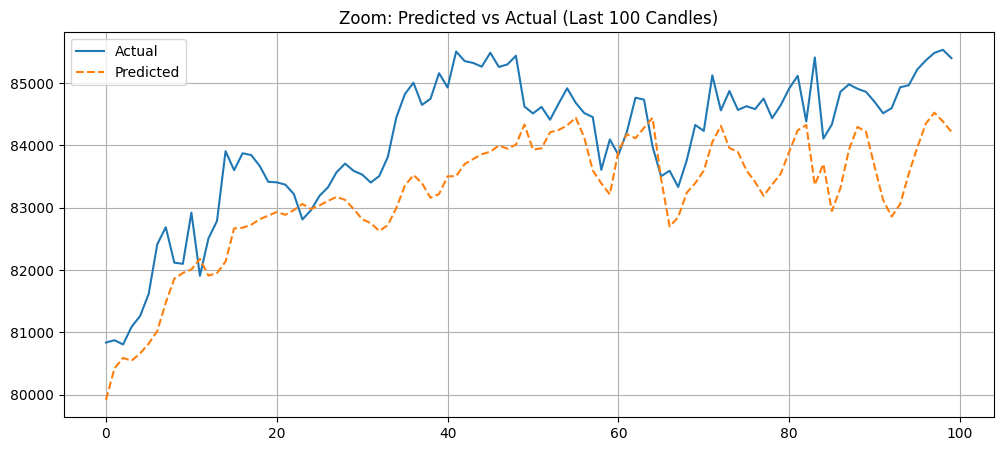

In [21]:
n = 100
plt.figure(figsize=(12, 5))
plt.plot(walk_truth_inv[-n:], label="Actual")
plt.plot(walk_preds_inv[-n:], label="Predicted", linestyle="--")
plt.title("Zoom: Predicted vs Actual (Last 100 Candles)")
plt.grid(True)
plt.legend()
plt.show()

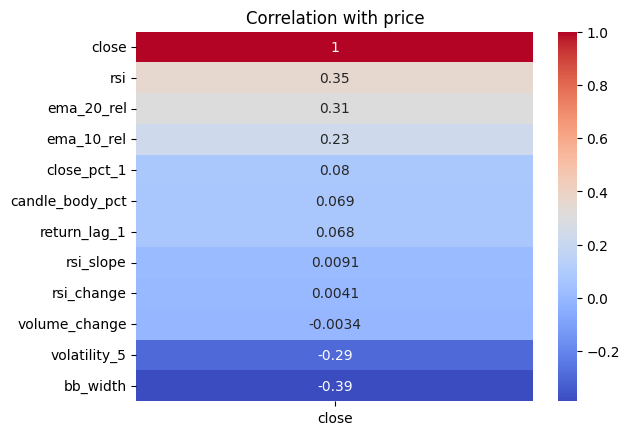

In [22]:
import seaborn as sns

selected_features = ['candle_body_pct','bb_width','close_pct_1','return_lag_1','volatility_5','volume_change','ema_10_rel','ema_20_rel','rsi','rsi_change','rsi_slope','close']
target_correlation = df_analyze[selected_features].corr()

sns.heatmap(target_correlation[['close']].sort_values(by='close', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with price")
plt.show()

### Forecasting
This part is more interesting than the previous part, because we can earn money if our prediction is correct hehehe. Kidding hehehe. Actually I don't want to trust the model because there are too many simplifications here, and I know quant trade has more data and more complicated models to understand bitcoin.

***So this is like a disclaimer to understand the context, this part doesn't need to be fully believed because what I'm doing here is just to train my thinking and how I can apply the knowledge I've gained so far in Data Science. Just for learning.***

In [23]:
forecast = []
input_seq = X_test[-1].copy()

for _ in range(12):
    pred_reg, pred_clf = model.predict(input_seq[np.newaxis, :, :], verbose=0)
    pred = pred_reg[0][0]
    forecast.append(pred)

    new_row = np.zeros_like(input_seq[0])
    new_row[0] = pred
    new_row[1:] = input_seq[-1, 1:]

    input_seq = np.vstack([input_seq[1:], new_row])

forecast_scaled = np.array(forecast).reshape(-1, 1)
forecast_scaled_2d = np.concatenate([forecast_scaled, np.zeros_like(forecast_scaled)], axis=1)
forecast_actual = scaler_y.inverse_transform(forecast_scaled_2d)[:, 0].flatten()

BTC price forecast (within the next 12 candles):
           Price
1   84711.046875
2   84638.000000
3   84742.328125
4   84868.296875
5   84985.921875
6   85106.773438
7   85169.953125
8   85141.023438
9   85043.062500
10  84919.750000
11  84809.750000
12  84735.085938


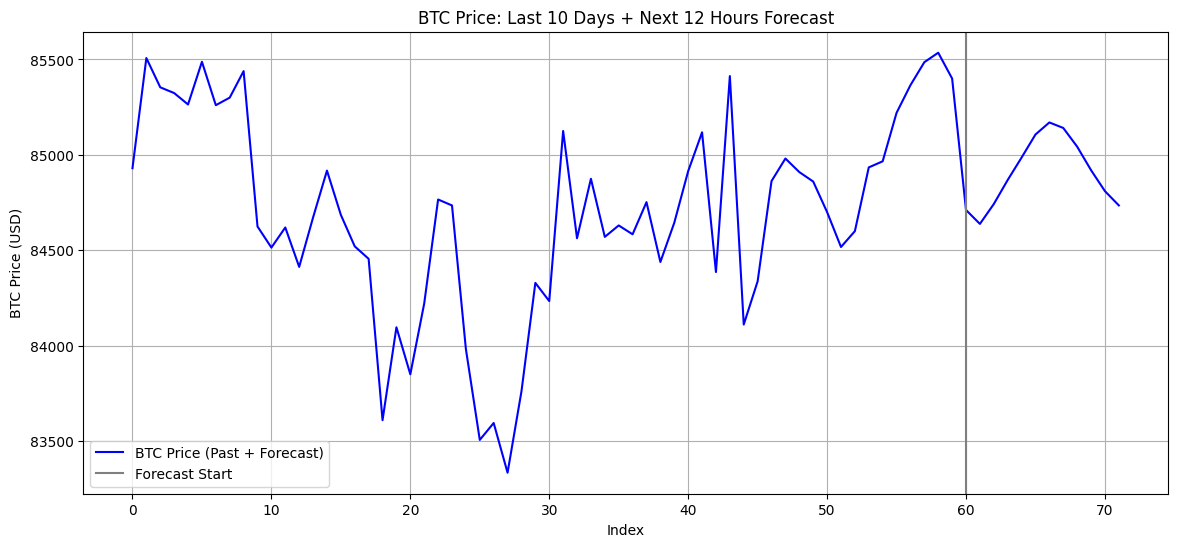

In [24]:
print("BTC price forecast (within the next 12 candles):")
forecast_actual = pd.DataFrame(forecast_actual, columns=['Price'])

forecast_actual.index = [i for i in range(1, 13)]

print(forecast_actual)

historical = df_analyze['close'].iloc[-60:].values
combined = np.concatenate([historical, forecast_actual['Price'].values])

plt.figure(figsize=(14, 6))
plt.plot(combined, label='BTC Price (Past + Forecast)', color='blue')
plt.axvline(x=60, color='gray', label='Forecast Start')
plt.title('BTC Price: Last 10 Days + Next 12 Hours Forecast')
plt.xlabel('Index')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Sentiment Analysis

In the world of trading, there are actually two different groups, one is people who just analyze the price (technical analysis), the other is people who analyze the macro-micro economy to understand what will happen to the price (fundamental analysis). And I want to combine both of them into one group here (to help me decide what to do with the current price, whether buy, sell or hold).

Actually I wanted to get the data from twitter but I couldn't get it, so I will get from two sources, first from CoinDesk and second from CryptoPanic

In [25]:
import requests
from bs4 import BeautifulSoup

def scrape_coindesk_with_content(max_articles=10):
    base_url = "https://www.coindesk.com/"
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    articles = []
    seen_urls = set()

    for link_tag in soup.find_all('a', href=True):
        href = link_tag['href']
        full_url = href if href.startswith("http") else f"https://www.coindesk.com{href}"
        if "/" in href and "video" not in href and full_url not in seen_urls and href.startswith(('/markets', '/business', '/tech')) and (href not in ['/markets', '/business', '/tech']):
            seen_urls.add(full_url)
            try:
                article_page = requests.get(full_url)
                article_soup = BeautifulSoup(article_page.content, 'html.parser')

                title_tag = article_soup.find(['h1', 'h2'])
                title = title_tag.get_text(strip=True) if title_tag else "No title"
                paragraphs = article_soup.find_all('p')
                content = " ".join(p.get_text(strip=True) for p in paragraphs[:5])

                articles.append({
                    'url': full_url,
                    'title': title,
                    'content': content
                })

                if len(articles) >= max_articles:
                    break

            except Exception as e:
                print(f"Error fetching {full_url}: {e}")
                continue

    return articles

news_articles = scrape_coindesk_with_content(25)
news_articles[0:3]

[{'url': 'https://www.coindesk.com/markets/2025/04/15/dogecoin-slumps-3-bitcoin-steady-around-usd85k-as-traders-fear-u-s-recession',
  'title': 'Dogecoin Slumps 3%, Bitcoin Steady Around $85K as Traders Fear U.S. Recession',
  'content': "Dogecoin (DOGE) shed 3% while bitcoin (BTC) and ether (ETH) remained flat in the past 24 hours as tariff concerns gradually subsided among traders, though fears of a U.S. recession increased in betting markets. “Prominent financial figures have started to warn that the U.S. is heading into an imminent recession, with betting markets placing 40% to 60% odds of one happening in 2025,” Augustine Fan, head of insights at SignalPlus, told CoinDesk in a Telegram message. “Our view is that it probably doesn't matter, as sentiment often frames reality, not the other way around.” “As such, crypto has benefited from the recent shake-out, as equities have been realizing higher volatility than Bitcoin through the risk-off move. A beggar-thy-neighbour policy with 

In [26]:
api_key = "api_key"

base_url = "https://cryptopanic.com/api/v1/posts/"

params = {
    'auth_token': api_key,
    'filter': 'trending',
    'currencies': 'BTC',
    'regions': 'en',
    'kind': 'news',
    'public': True
}

response = requests.get(base_url, params=params)
news_data = []

if response.status_code == 200:
    data = response.json()
    for item in data['results']:
        title = item['title']
        url = item['url']
        source = item['source']['title']
        created_at = item['created_at']

        if 'currencies' in item:
            currencies = ', '.join([c['code'] for c in item['currencies']])
        else:
            currencies = ''


        news_item = {
            'judul': title,
            'url': url,
            'sumber': source,
            'waktu': created_at,
            'mata_uang': currencies,
            'content':title
        }

        news_data.append(news_item)

news_data[0:3]

[{'judul': 'MicroStrategy Acquires 3,459 Bitcoins for $285.8 Million, Total Holdings Reach 531,644 BTC',
  'url': 'https://cryptopanic.com/news/21072568/MicroStrategy-Acquires-3459-Bitcoins-for-2858-Million-Total-Holdings-Reach-531644-BTC?mtm_campaign=API-OFA',
  'sumber': 'DeFi News',
  'waktu': '2025-04-14T14:30:40Z',
  'mata_uang': 'BTC',
  'content': 'MicroStrategy Acquires 3,459 Bitcoins for $285.8 Million, Total Holdings Reach 531,644 BTC'},
 {'judul': 'Saylor’s Strategy adds 3,459 Bitcoin, now holds 531,644 BTC',
  'url': 'https://cryptopanic.com/news/21069129/Saylors-Strategy-adds-3459-Bitcoin-now-holds-531644-BTC?mtm_campaign=API-OFA',
  'sumber': 'CryptoBriefing',
  'waktu': '2025-04-14T12:03:51Z',
  'mata_uang': 'BTC',
  'content': 'Saylor’s Strategy adds 3,459 Bitcoin, now holds 531,644 BTC'},
 {'judul': 'Saylor signals new Bitcoin buy after Strategy reports nearly $6 billion Q1 unrealized loss',
  'url': 'https://cryptopanic.com/news/21056879/Saylor-signals-new-Bitcoin-buy

In [27]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

all_articles = news_articles + news_data
df_news = pd.DataFrame(all_articles)
df_news['content'] = df_news['content'].astype(str)

def vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_news['sentimen'] = df_news['content'].apply(vader_sentiment)

df_news[['title', 'sentimen']].head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,title,sentimen
0,"Dogecoin Slumps 3%, Bitcoin Steady Around $85K...",Negative
1,Nomura's Laser Digital Denies Involvement in M...,Negative
2,"Bitcoin Faces 'Cloud Resistance' at $85K, Neut...",Positive
3,"XRP, SOL and ADA Flash Bullish Patterns as Tra...",Positive
4,Metaplanet Becomes 10th Largest Public Bitcoin...,Positive


In [28]:
sentiment_counts = df_news['sentimen'].value_counts()
dominant_sentiment = sentiment_counts.idxmax()
jumlah_dominan = sentiment_counts.max()
total_berita = sentiment_counts.sum()

print("News Sentiment Conclusion (VADER)")
print(f"Total news analyzed: {total_berita}")
print(f"Dominant sentiment: {dominant_sentiment} ({jumlah_dominan} news)")
print("\nComplete distribution:")
print(sentiment_counts)

News Sentiment Conclusion (VADER)
Total news analyzed: 37
Dominant sentiment: Positive (14 news)

Complete distribution:
sentimen
Positive    14
Negative    13
Neutral     10
Name: count, dtype: int64


### Decision

In [29]:
prediction_sentiment = ''
if df_analyze.iloc[-1]['close'] > forecast_actual['Price'].mean():
  prediction_sentiment = 'Negative'
elif df_analyze.iloc[-1]['close'] < forecast_actual['Price'].mean():
  prediction_sentiment = 'Positive'
else:
  prediction_sentiment = 'Neutral'

def signal(prediction_sentiment, dominant_sentiment):
    if prediction_sentiment == "Positive":
        if dominant_sentiment == "Positive":
            return "BUY"
        elif dominant_sentiment == "Neutral":
            return "WAIT"
        else:
            return "CAUTION"
    elif prediction_sentiment == "Negative":
        if dominant_sentiment == "Negative":
            return "SELL"
        elif dominant_sentiment == "Positive":
            return "CAUTION"
        else:
            return "WAIT"
    else:
        return "HOLD"

trading_signal = signal(prediction_sentiment, dominant_sentiment)

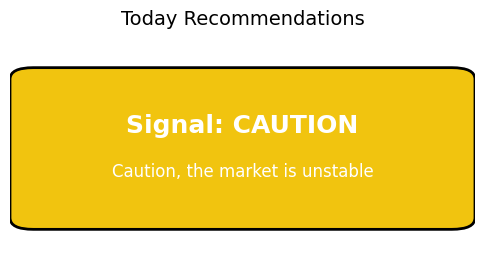

In [30]:
from matplotlib.patches import FancyBboxPatch

color_map = {
    "BUY": "#27ae60",
    "SELL": "#c0392b",
    "WAIT": "#f39c12",
    "CAUTION": "#f1c40f",
    "HOLD": "#7f8c8d"
}

message_map = {
    "BUY": "Time to buy!",
    "SELL": "Consider selling",
    "WAIT": "Wait for confirmation",
    "CAUTION": "Caution, the market is unstable",
    "HOLD": "Hold the position"
}


fig, ax = plt.subplots(figsize=(6, 3))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

box = FancyBboxPatch((0.05, 0.2), 0.9, 0.6,
                      boxstyle="round,pad=0.05",
                      linewidth=2,
                      facecolor=color_map.get(trading_signal, "#7f8c8d"),
                      edgecolor='black')
ax.add_patch(box)

ax.text(0.5, 0.6, f"Signal: {trading_signal}", fontsize=18, weight='bold',
        color='white', ha='center', va='center')

ax.text(0.5, 0.4, message_map.get(trading_signal, ""), fontsize=12,
        color='white', ha='center', va='center')

plt.title("Today Recommendations", fontsize=14)
plt.show()